In [76]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [77]:
raw_data = load_iris()
raw_data

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [78]:
print(raw_data.target_names)

['setosa' 'versicolor' 'virginica']


In [79]:
def preprocess(data):
  df = pd.DataFrame(data.data, columns=data.feature_names)
  df['label'] = data.target
  df = df[(df.label == 1) | (df.label == 0)]
  df['label'] = (df['label']==0).astype(int)
  return df;

data = preprocess(raw_data)
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,0
96,5.7,2.9,4.2,1.3,0
97,6.2,2.9,4.3,1.3,0
98,5.1,2.5,3.0,1.1,0


In [80]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [81]:
def calculate_entropy(y):
  p = y.mean() #= p_setosa (and p_versicolor = 1-p_setosa)
  return -p*np.log2(p) - (1-p)*np.log2(1-p)

In [82]:
def information_gain(y, y_left, y_right):
  n = len(y)
  n_l = len(y_left)
  n_r = len(y_right)
  return calculate_entropy(y) - n_l/n*calculate_entropy(y_left) - n_r/n*calculate_entropy(y_right)

In [83]:
def best_split(X, y):
  best_feature = None
  best_threshold = None
  best_gain = 0
  for i in range(X.shape[1]):
    thresholds = np.unique(X[:, i])
    for t in thresholds:
      y_left = y[X[:, i] < t]
      y_right = y[X[:, i] >= t]
      gain = information_gain(y, y_left, y_right)
      if gain > best_gain:
        best_gain = gain
        best_feature = i
        best_threshold = t
  return best_feature, best_threshold

In [84]:
class Node:
  def __init__(self, depth):
    self.depth = depth
    self.feature = None
    self.threshold = None
    self.left = None
    self.right = None
    self.prediction = None
  

In [85]:
def build_tree(X, y, max_depth):
  if max_depth == 0 or len(np.unique(y)) == 1:
    leaf = Node(max_depth)
    leaf.prediction = np.argmax(np.bincount(y.astype(int)))
    return leaf
  feature, threshold = best_split(X, y)
  if feature is None:
    leaf = Node(max_depth)
    leaf.prediction = np.argmax(np.bincount(y.astype(int)))
    return leaf
  node = Node(max_depth)
  node.feature = feature
  node.threshold = threshold
  X_left = X[X[:, feature] < threshold]
  y_left = y[X[:, feature] < threshold]
  X_right = X[X[:, feature] >= threshold]
  y_right = y[X[:, feature] >= threshold]
  node.left = build_tree(X_left, y_left, max_depth-1)
  node.right = build_tree(X_right, y_right, max_depth-1)
  return node

In [86]:
def predict_single_instance(x, tree):
  if tree.prediction is not None:
    return (tree.prediction>=0.5).astype(int)
  if x[tree.feature] < tree.threshold:
    return predict_single_instance(x, tree.left)
  else:
    return predict_single_instance(x, tree.right)

In [87]:
def predict_decision_tree(X_test, tree):
  return np.array([predict_single_instance(x, tree) for x in X_test])

In [88]:
def accuracy(y_true, y_pred):
  return np.mean(y_true == y_pred)

In [89]:
'''Measure and print the accuracy of the Decision Tree on both
the train and test sets.'''
X_train = train.drop('label', axis=1).values
y_train = train['label'].values
X_test = test.drop('label', axis=1).values
y_test = test['label'].values

tree = build_tree(X_train, y_train, 3)
y_train_pred = predict_decision_tree(X_train, tree)
y_test_pred = predict_decision_tree(X_test, tree)
acc_train = accuracy(y_train, y_train_pred)
acc_test = accuracy(y_test, y_test_pred)
print(f'Train accuracy: {acc_train:.2f}')
print(f'Test accuracy: {acc_test:.2f}')


Train accuracy: 0.94
Test accuracy: 0.90


C:\Users\Hp\AppData\Local\Temp\ipykernel_3024\3231649947.py:2: RuntimeWarning: Mean of empty slice.
  p = y.mean() #= p_setosa (and p_versicolor = 1-p_setosa)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Hp\AppData\Local\Temp\ipykernel_3024\3231649947.py:3: RuntimeWarning: divide by zero encountered in log2
  return -p*np.log2(p) - (1-p)*np.log2(1-p)
C:\Users\Hp\AppData\Local\Temp\ipykernel_3024\3231649947.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  return -p*np.log2(p) - (1-p)*np.log2(1-p)


In [90]:
# Compare the results from your implementation with scikit-learn’s version
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth=9, random_state=42)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
print(f'Train accuracy: {acc_train:.2f}')
print(f'Test accuracy: {acc_test:.2f}')


Train accuracy: 1.00
Test accuracy: 1.00


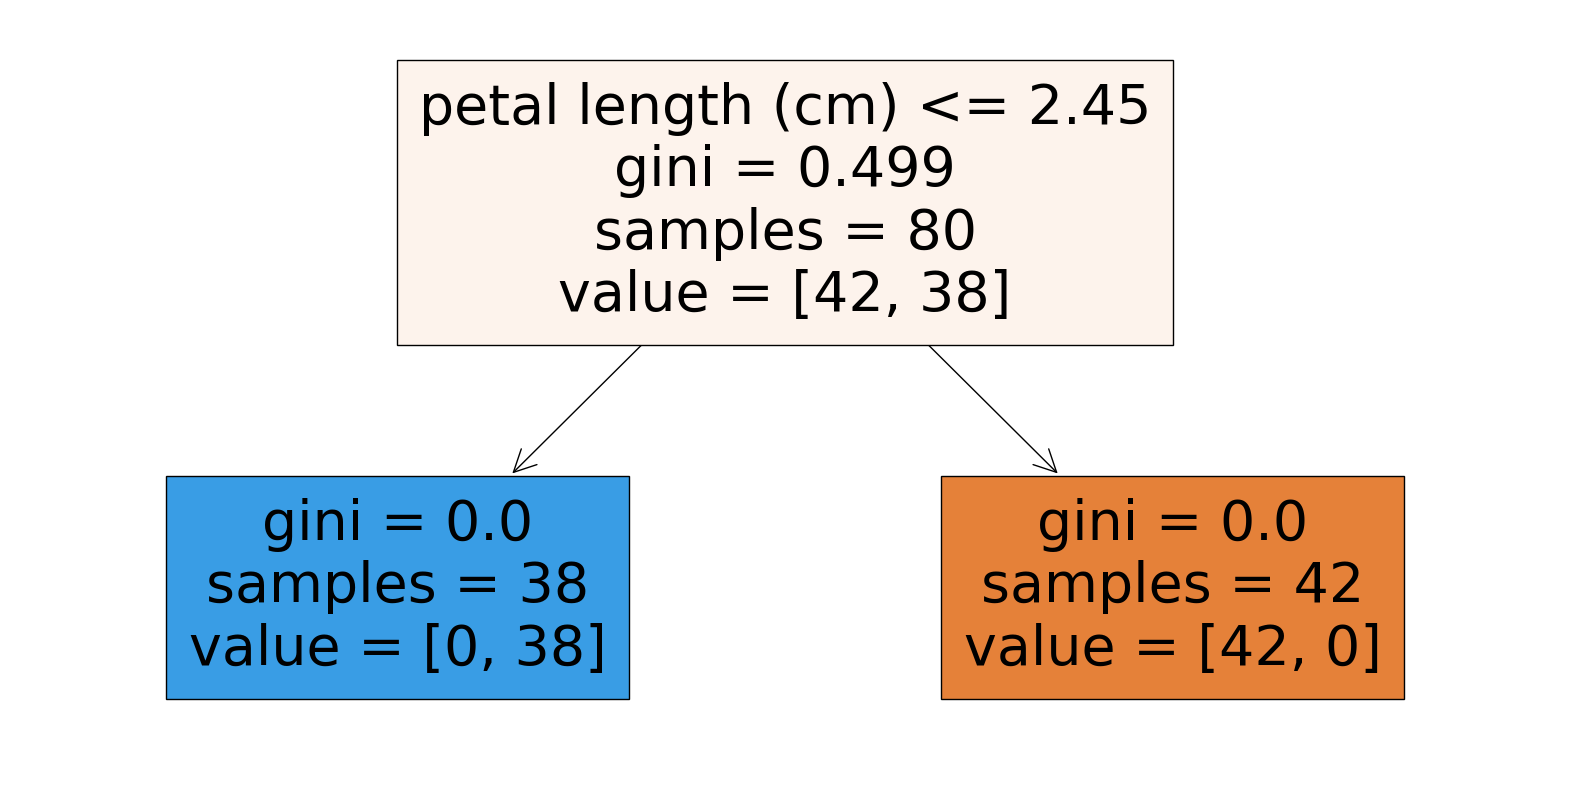

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=data.columns[:-1], filled=True)
plt.show()